In [40]:
import open3d as o3d
import pyrealsense2 as rs
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import itertools
from winsound import Beep
from scipy.spatial.distance import directed_hausdorff

def save_pcl(number, pointcloud1, pointcloud2, folder):
    p1_colors = pointcloud1.colors
    p2_colors = pointcloud2.colors
    p1_load = pointcloud1.points
    p2_load = pointcloud2.points
    p3_colors = np.concatenate((p1_colors, p2_colors), axis=0)
    p3_load = np.concatenate((p1_load, p2_load), axis=0)
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(p3_load)
    pcd.colors = o3d.utility.Vector3dVector(p3_colors)
    o3d.io.write_point_cloud(f'./acquisizioni/{folder}/{number}_l.pcd', pointcloud1, write_ascii=False, compressed=False, print_progress=False)
    o3d.io.write_point_cloud(f'./acquisizioni/{folder}/{number}_r.pcd', pointcloud2, write_ascii=False, compressed=False, print_progress=False)
    o3d.io.write_point_cloud(f'./acquisizioni/{folder}/{number}.pcd', pcd, write_ascii=False, compressed=False, print_progress=False)
    return True

In [4]:
def acquire(n_frames):
    nframes = n_frames

    # Camera RIGHT
    pipeline = rs.pipeline()
    config = rs.config()
    config.enable_device('233722072412')
    pipeline_wrapper = rs.pipeline_wrapper(pipeline)
    pipeline_profile = config.resolve(pipeline_wrapper)
    device = pipeline_profile.get_device()
    advnc_mode = rs.rs400_advanced_mode(device)
    current_std_depth_table = advnc_mode.get_depth_table()
    current_std_depth_table.depthClampMin = 0
    current_std_depth_table.depthClampMax = 800
    advnc_mode.set_depth_table(current_std_depth_table)
    config.enable_stream(rs.stream.depth, 1280, 720, rs.format.z16, 30)
    config.enable_stream(rs.stream.color, 1280, 720, rs.format.bgr8, 30)

    align = rs.align(rs.stream.depth)

    # Camera LEFT
    pipeline_2 = rs.pipeline()
    config_2 = rs.config()
    config_2.enable_device('032622070359')
    pipeline_wrapper_2 = rs.pipeline_wrapper(pipeline_2)
    pipeline_profile_2 = config_2.resolve(pipeline_wrapper_2)
    device_2 = pipeline_profile_2.get_device()
    advnc_mode_2 = rs.rs400_advanced_mode(device_2)
    current_std_depth_table_2 = advnc_mode_2.get_depth_table()
    current_std_depth_table_2.depthClampMin = 0
    current_std_depth_table_2.depthClampMax = 800
    advnc_mode_2.set_depth_table(current_std_depth_table_2)
    config_2.enable_stream(rs.stream.depth, 1280, 720, rs.format.z16, 30)
    config_2.enable_stream(rs.stream.color, 1280, 720, rs.format.bgr8, 30)


    cfg = pipeline.start(config)
    profile = cfg.get_stream(rs.stream.depth)
    intr_right = profile.as_video_stream_profile().get_intrinsics()

    cfg_2 = pipeline_2.start(config_2)
    profile_2 = cfg_2.get_stream(rs.stream.depth)
    intr_left = profile_2.as_video_stream_profile().get_intrinsics()

    depths_left = []
    depths_right = []
    cnt = 0
    print("Acquisizione iniziata")
    while cnt<=90+nframes:
        # RIGHT
        frames = pipeline.wait_for_frames()
        frames = align.process(frames)
        depth_frame = frames.get_depth_frame()
        depth_image = np.asarray(depth_frame.get_data())
        if cnt>90:
            depths_right.append(depth_image)
        color_frame = frames.get_color_frame()
        color_image = np.asarray(color_frame.get_data())

        #LEFT
        frames_2 = pipeline_2.wait_for_frames()
        frames_2 = align.process(frames_2)
        depth_frame_2 =frames_2.get_depth_frame()
        depth_image_2 = np.asarray(depth_frame_2.get_data())
        if cnt>=90:
            depths_left.append(depth_image_2)
        color_frame_2 = frames_2.get_color_frame()
        color_image_2 = np.asarray(color_frame_2.get_data())

        cnt += 1

    pipeline.stop()
    pipeline_2.stop()
    print("Acquisizione finita")
    variances_left = np.zeros((720, 1280))
    means_left = np.zeros((720, 1280))
    inliers_left = np.zeros((720, 1280))
    variances_right = np.zeros((720, 1280))
    means_right = np.zeros((720, 1280))
    inliers_right = np.zeros((720, 1280))
    for i in range(0, 720):
        for j in range(0, 1280):
            support_left = []
            support_right = []
            for k in range(0, nframes):
                if depths_left[k][i][j] > 0:
                    support_left.append(depths_left[k][i][j])
                if depths_right[k][i][j] > 0:
                    support_right.append(depths_right[k][i][j])
            if len(support_left) > 0:
                inliers_left[i,j] = len(support_left)
                variances_left[i,j] = np.var(support_left)
                means_left [i,j] = np.mean(support_left)
            else:
                variances_left[i,j] = -1
            if len(support_right) > 0:
                inliers_right[i,j] = len(support_right)
                variances_right[i,j] = np.var(support_right)
                means_right [i,j] = np.mean(support_right)
            else:
                variances_right[i,j] = -1
    return depths_left, variances_left, means_left, inliers_left, color_image_2, depths_right, variances_right, means_right, inliers_right, color_image, intr_left, intr_right

In [5]:
# LEFT
def get_maps(variances, means, threshold=None):
    max_value = variances.max()
    invalid_indexes = np.argwhere(variances==-1)
    valid_variances = np.copy(variances)
    valid_variances[invalid_indexes[:,0], invalid_indexes[:,1]] = max_value
    if threshold is None:
        threshold = np.median(variances[variances!=-1])
    print(f'Threshold: {np.median(variances[variances!=-1])}')

    from scipy.interpolate import interp1d

    img_indexes = np.argwhere(valid_variances<threshold)
    high_variance_indexes = np.argwhere(valid_variances>=threshold)

    
    filtered_means = np.copy(means)
    filtered_means[high_variance_indexes[:,0], high_variance_indexes[:,1]] = 0
    zero_variance_indexes = np.argwhere(valid_variances==0)
    zero_variance_image = np.zeros((720, 1280))
    zero_variance_image[zero_variance_indexes[:,0], zero_variance_indexes[:,1]] = 255

    variance_image = np.zeros((720, 1280))
    m = interp1d([valid_variances.min(),threshold],[0,254])
    variance_image[img_indexes[:,0], img_indexes[:,1]] =  m(valid_variances[img_indexes[:,0], img_indexes[:,1]])

    variance_image[high_variance_indexes[:,0], high_variance_indexes[:,1]] = 255

    return variance_image, zero_variance_image, threshold, filtered_means

# CALIBRAZIONE

In [6]:
d_l, v_l, m_l, in_l, col_l, d_r, v_r, m_r, in_r, col_r, intr_left, intr_right = acquire(90)

Acquisizione iniziata
Acquisizione finita


In [7]:
variance_image_l, zero_variance_image_l, threshold_l, filtered_means_l = get_maps(v_l, m_l, 1)
variance_image_r, zero_variance_image_r, threshold_r, filtered_means_r = get_maps(v_r, m_r, 1)

Threshold: 0.16654320987654314
Threshold: 0.18580246913580245


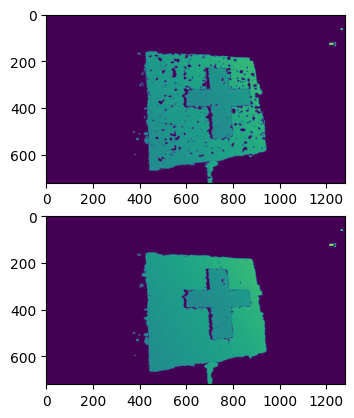

In [8]:
plt.subplot(2,1,1)
plt.imshow(filtered_means_l)
plt.subplot(2,1,2)
plt.imshow(m_l)
plt.show()

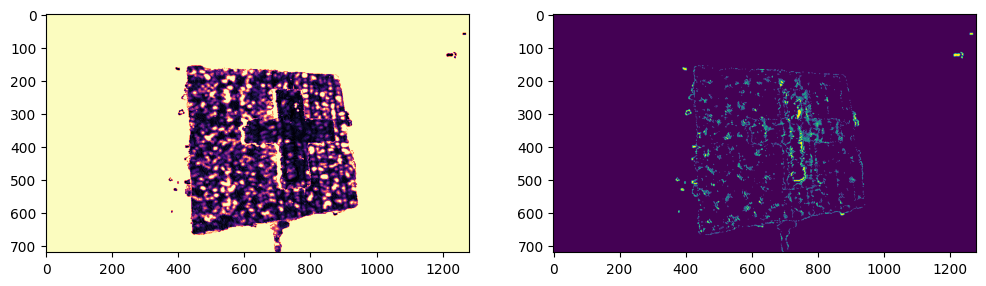

LEFT IMAGE: variance map with max value: 1 mm
RIGHT IMAGE: Zero variance map


In [9]:
from matplotlib import pyplot as plt
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(variance_image_l, cmap="magma")
cv2.imwrite("varianza zero.png", variance_image_l)
plt.subplot(1,2,2)
plt.imshow(zero_variance_image_l)
plt.show()
print(f'LEFT IMAGE: variance map with max value: {threshold_l} mm\nRIGHT IMAGE: Zero variance map')

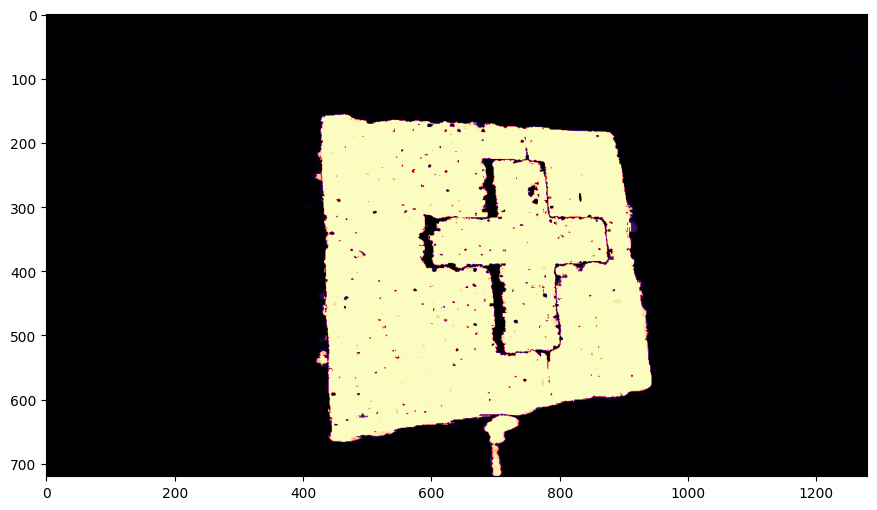

In [10]:
# Inliers map
from scipy.interpolate import interp1d

m = interp1d([in_l.min(),in_l.max()],[0,255])
inliers_map = m(in_l)
plt.figure(figsize=(12,6))
plt.imshow(inliers_map, cmap="magma")
plt.show()

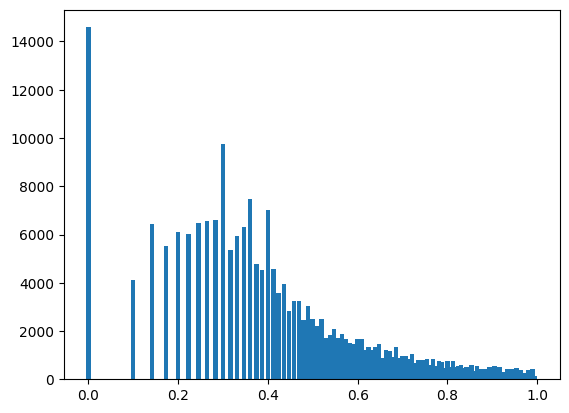

In [11]:
valid = v_l[v_l>-1]
hist_variance, aa = np.histogram(valid[valid < threshold_l], bins=100)
plt.bar(np.sqrt(aa[:-1]), hist_variance, width=threshold_l/100)  # arguments are passed to np.histogram
plt.show()

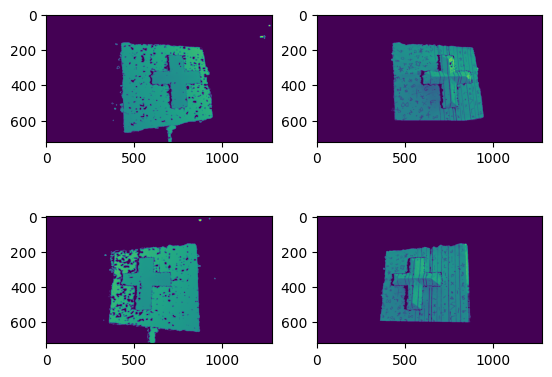

In [12]:
indexes = np.argwhere(variance_image_l == 255)
selected_m_l = np.copy(m_l)
selected_m_l[indexes[:,0], indexes[:,1]] = 0
cv2.imwrite("leftDepth.png", np.uint16(selected_m_l))
cv2.imwrite("leftColor.jpg", col_l)

indexes = np.argwhere(variance_image_r == 255)
selected_m_r = np.copy(m_r)
selected_m_r[indexes[:,0], indexes[:,1]] = 0
cv2.imwrite("rightDepth.png", np.uint16(selected_m_r))
cv2.imwrite("rightColor.jpg", col_r)


depth_raw_left = o3d.io.read_image("leftDepth.png")
color_raw_left = o3d.io.read_image("leftColor.jpg")
depth_raw_right = o3d.io.read_image("rightDepth.png")
color_raw_right = o3d.io.read_image("rightColor.jpg")
rgbd_image_left = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw_left, depth_raw_left)
rgbd_image_right = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw_right, depth_raw_right)

plt.subplot(2,2,1)
plt.imshow(rgbd_image_left.depth)
plt.subplot(2,2,2)
plt.imshow(rgbd_image_left.color)
plt.subplot(2,2,3)
plt.imshow(rgbd_image_right.depth)
plt.subplot(2,2,4)
plt.imshow(rgbd_image_right.color)
plt.show()

In [13]:
import copy

def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    #target_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp],
                                      zoom=0.4459,
                                      front=[1.0, 0.0, 0.0],
                                      lookat=[1, 0, 0],
                                      up=[-0., 1, -0.0])

In [14]:
camera_intrinsic_left = o3d.camera.PinholeCameraIntrinsic(o3d.camera.PinholeCameraIntrinsic(
    intr_left.width, intr_left.height, intr_left.fx, intr_left.fy, intr_left.ppx, intr_left.ppy
))
camera_intrinsic_right = o3d.camera.PinholeCameraIntrinsic(o3d.camera.PinholeCameraIntrinsic(
    intr_right.width, intr_right.height, intr_right.fx, intr_right.fy, intr_right.ppx, intr_right.ppy
))

pcd_left = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image_left, camera_intrinsic_left)
pcd_right = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image_right, camera_intrinsic_right)

bounds = [[-math.inf, math.inf], [-math.inf, math.inf], [0.2, 0.7]]  # set the bounds
bounding_box_points = list(itertools.product(*bounds))  # create limit points
bounding_box = o3d.geometry.AxisAlignedBoundingBox.create_from_points(o3d.utility.Vector3dVector(bounding_box_points))  # create bounding box object

# Crop the point cloud using the bounding box:
pcd_left = pcd_left.crop(bounding_box)
pcd_right = pcd_right.crop(bounding_box)

# Rotazione di 180° intorno all'asse X (ribaltare la point cloud poiché la pinhole camera ribalta la visuale)
angolo = np.pi
trans_x = np.asarray([   [1.0, 0.0, 0.0, 0.0],
                         [0.0, np.cos(angolo), -np.sin(angolo), 0.0],
                         [0.0, np.sin(angolo), np.cos(angolo), 0.0],
                         [0.0, 0.0, 0.0, 1.0]])

pcd_left.transform(trans_x)
pcd_right.transform(trans_x)

# Primario -> Camera di destra 
# Secondario -> Camera di sinistra

# Rotazione di -30° intorno all'asse Y
angolo = np.pi/6
trans_y = np.asarray([[np.cos(angolo), 0.0, np.sin(angolo), -0.34],
                         [0.0, 1.0, 0.0, 0.0],
                         [-np.sin(angolo), 0.0, np.cos(angolo), 0.0],
                         [0.0, 0.0, 0.0, 1.0]])

#pcd_left.transform(trans_y)

#pcd_left.paint_uniform_color((1,0,0))  # LEFT BLU

#pcd_right.paint_uniform_color((0,0,1)) # RIGHT ROSSO

o3d.visualization.draw_geometries([pcd_left, pcd_right])

[Open3D WARNING] [ViewControl] SetViewPoint() failed because window height and width are not set.
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: Handle non valido. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: L'operazione di trasformazione richiesta non è supportata. 


In [15]:
angolo = np.pi/6
source = pcd_left
target = pcd_right
#target.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.05, max_nn=400))
#target.orient_normals_consistent_tangent_plane(50)
threshold = 0.01
trans_init = np.asarray([[np.cos(angolo), 0.0, -np.sin(angolo), -0.31],
                         [0.0, 1.0, 0.0, 0.0],
                         [np.sin(angolo), 0.0, np.cos(angolo), -0.1],
                         [0.0, 0.0, 0.0, 1.0]])
draw_registration_result(source, target, trans_init)

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: Handle non valido. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: L'operazione di trasformazione richiesta non è supportata. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: Handle non valido. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: Handle non valido. 


In [16]:
print("Initial alignment")
evaluation = o3d.pipelines.registration.evaluate_registration(
    source, target, threshold, trans_init)
print(evaluation)

Initial alignment
RegistrationResult with fitness=7.136857e-01, inlier_rmse=5.558446e-03, and correspondence_set size of 145786
Access transformation to get result.


In [17]:
print("Apply point-to-plane ICP")
reg_p2p = o3d.pipelines.registration.registration_icp(
    source, target, threshold, trans_init,
    o3d.pipelines.registration.TransformationEstimationPointToPoint(),
    o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=1000000, relative_rmse=0.001))
print(reg_p2p)
print("Transformation is:")
print(reg_p2p.transformation)
draw_registration_result(source, target, reg_p2p.transformation)


Apply point-to-plane ICP
RegistrationResult with fitness=9.251635e-01, inlier_rmse=2.098092e-03, and correspondence_set size of 188985
Access transformation to get result.
Transformation is:
[[ 0.82782547 -0.01072246 -0.56088325 -0.31326307]
 [ 0.0180367   0.99980914  0.00750748 -0.00184767]
 [ 0.5606957  -0.01633137  0.82786087 -0.10924572]
 [ 0.          0.          0.          1.        ]]


In [20]:
print("Apply point-to-point ICP")
reg_p2p = o3d.pipelines.registration.registration_icp(
    source, target, threshold, trans_init,
    o3d.pipelines.registration.TransformationEstimationPointToPoint(),
    o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=10000))
print(reg_p2p)
print("Transformation is:")
print(reg_p2p.transformation)
draw_registration_result(source, target, reg_p2p.transformation)

Apply point-to-point ICP


RuntimeError: [Open3D Error] (class open3d::pipelines::registration::RegistrationResult __cdecl open3d::pipelines::registration::RegistrationICP(const class open3d::geometry::PointCloud &,const class open3d::geometry::PointCloud &,double,const class Eigen::Matrix<double,4,4,0,4,4> &,const class open3d::pipelines::registration::TransformationEstimation &,const class open3d::pipelines::registration::ICPConvergenceCriteria &)) D:\a\Open3D\Open3D\cpp\open3d\pipelines\registration\Registration.cpp:128: TransformationEstimationPointToPlane and TransformationEstimationColoredICP require pre-computed normal vectors for target PointCloud.


In [18]:
calibrated_matrix = reg_p2p.transformation
calibrated_matrix

array([[ 0.82782547, -0.01072246, -0.56088325, -0.31326307],
       [ 0.0180367 ,  0.99980914,  0.00750748, -0.00184767],
       [ 0.5606957 , -0.01633137,  0.82786087, -0.10924572],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [19]:
pcd_left = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image_left, camera_intrinsic_left)
pcd_right = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image_right, camera_intrinsic_right)

bounds = [[-math.inf, math.inf], [-math.inf, 0.15], [0.1, 1.0]]  # set the bounds
bounding_box_points = list(itertools.product(*bounds))  # create limit points
bounding_box = o3d.geometry.AxisAlignedBoundingBox.create_from_points(o3d.utility.Vector3dVector(bounding_box_points))  # create bounding box object

# Crop the point cloud using the bounding box:
pcd_left = pcd_left.crop(bounding_box)
pcd_right = pcd_right.crop(bounding_box)

# Rotazione di 180° intorno all'asse X (ribaltare la point cloud poiché la pinhole camera ribalta la visuale)
angolo = np.pi
trans_x = np.asarray([   [1.0, 0.0, 0.0, 0.0],
                         [0.0, np.cos(angolo), -np.sin(angolo), 0.0],
                         [0.0, np.sin(angolo), np.cos(angolo), 0.0],
                         [0.0, 0.0, 0.0, 1.0]])

pcd_left.transform(trans_x)
pcd_right.transform(trans_x)


pcd_left.transform(calibrated_matrix)

#pcd_left.paint_uniform_color((1,0,0))  # LEFT BLU

#pcd_right.paint_uniform_color((0,0,1)) # RIGHT ROSSO

o3d.visualization.draw_geometries([pcd_left, pcd_right])

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: Handle non valido. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: Handle non valido. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: Handle non valido. 


In [115]:
test = pcd_left
p1_load = np.asarray(test.points)
p1_color = np.asarray(test.colors)
p2_load = np.asarray(pcd_right.points)
p2_color = np.asarray(pcd_right.colors)

p3_load = np.concatenate((p1_load, p2_load), axis=0)
p3_color = np.concatenate((p1_color, p2_color), axis=0)

new_pcd = o3d.geometry.PointCloud()
new_pcd.points = o3d.utility.Vector3dVector(p3_load)
new_pcd.colors = o3d.utility.Vector3dVector(p3_color)

In [120]:
save_pcl(1, pcd_left, pcd_right, 'tre')

True

In [116]:
o3d.visualization.draw_geometries([new_pcd])

# ACQUISIZIONE

In [41]:
def one_shot():
    # Camera RIGHT
    pipeline = rs.pipeline()
    config = rs.config()
    config.enable_device('233722072412')
    pipeline_wrapper = rs.pipeline_wrapper(pipeline)
    pipeline_profile = config.resolve(pipeline_wrapper)
    device = pipeline_profile.get_device()
    advnc_mode = rs.rs400_advanced_mode(device)
    current_std_depth_table = advnc_mode.get_depth_table()
    current_std_depth_table.depthClampMin = 0
    current_std_depth_table.depthClampMax = 800
    advnc_mode.set_depth_table(current_std_depth_table)
    config.enable_stream(rs.stream.depth, 1280, 720, rs.format.z16, 30)
    config.enable_stream(rs.stream.color, 1280, 720, rs.format.bgr8, 30)

    # Camera LEFT
    pipeline_2 = rs.pipeline()
    config_2 = rs.config()
    config_2.enable_device('032622070359')
    pipeline_wrapper_2 = rs.pipeline_wrapper(pipeline_2)
    pipeline_profile_2 = config_2.resolve(pipeline_wrapper_2)
    device_2 = pipeline_profile_2.get_device()
    advnc_mode_2 = rs.rs400_advanced_mode(device_2)
    current_std_depth_table_2 = advnc_mode_2.get_depth_table()
    current_std_depth_table_2.depthClampMin = 0
    current_std_depth_table_2.depthClampMax = 800
    advnc_mode_2.set_depth_table(current_std_depth_table_2)
    config_2.enable_stream(rs.stream.depth, 1280, 720, rs.format.z16, 30)
    config_2.enable_stream(rs.stream.color, 1280, 720, rs.format.bgr8, 30)


    align = rs.align(rs.stream.depth)
    cfg = pipeline.start(config)
    profile = cfg.get_stream(rs.stream.depth)
    intr_right = profile.as_video_stream_profile().get_intrinsics()

    cfg_2 = pipeline_2.start(config_2)
    profile_2 = cfg_2.get_stream(rs.stream.depth)
    intr_left = profile_2.as_video_stream_profile().get_intrinsics()

    cnt = 0
    #print("Acquisizione iniziata")
    while cnt<=90:
        cnt += 1
        frames = pipeline.wait_for_frames()
        frames = align.process(frames)
        frames_2 = pipeline_2.wait_for_frames()
        frames_2 = align.process(frames_2)
    #print("\n\n----  CHEESE :-)  ---- \n\n")
    # RIGHT
    frames = pipeline.wait_for_frames()
    frames = align.process(frames)
    depth_frame = frames.get_depth_frame()
    depth_image = np.asarray(depth_frame.get_data())
    color_frame = frames.get_color_frame()
    color_image = np.asarray(color_frame.get_data())

    #LEFT
    frames_2 = pipeline_2.wait_for_frames()
    frames_2 = align.process(frames_2)
    depth_frame_2 =frames_2.get_depth_frame()
    depth_image_2 = np.asarray(depth_frame_2.get_data())
    color_frame_2 = frames_2.get_color_frame()
    color_image_2 = np.asarray(color_frame_2.get_data())
    pipeline.stop()
    pipeline_2.stop()


    #print("Acquisizione finita")
    
    return depth_image_2, color_image_2, intr_left, depth_image, color_image, intr_right



In [53]:
matrice_calibrazione = calibrated_matrix

for i in range(1,2):
    depth_image_l, color_image_l, intr_left, depth_image_r, color_image_r, intr_right = one_shot()
    cv2.imwrite("leftDepth.png", depth_image_l)
    cv2.imwrite("leftColor.jpg", color_image_l)

    cv2.imwrite("rightDepth.png", depth_image_r)
    cv2.imwrite("rightColor.jpg", color_image_r)

    depth_raw_left = o3d.io.read_image("leftDepth.png")
    color_raw_left = o3d.io.read_image("leftColor.jpg")
    depth_raw_right = o3d.io.read_image("rightDepth.png")
    color_raw_right = o3d.io.read_image("rightColor.jpg")
    rgbd_image_left = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw_left, depth_raw_left, convert_rgb_to_intensity=False)
    rgbd_image_right = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw_right, depth_raw_right, convert_rgb_to_intensity=False)
    camera_intrinsic_left = o3d.camera.PinholeCameraIntrinsic(o3d.camera.PinholeCameraIntrinsic(
        intr_left.width, intr_left.height, intr_left.fx, intr_left.fy, intr_left.ppx, intr_left.ppy
    ))
    camera_intrinsic_right = o3d.camera.PinholeCameraIntrinsic(o3d.camera.PinholeCameraIntrinsic(
        intr_right.width, intr_right.height, intr_right.fx, intr_right.fy, intr_right.ppx, intr_right.ppy
    ))

    pcd_left = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image_left, camera_intrinsic_left)
    pcd_right = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image_right, camera_intrinsic_right)

    bounds = [[-math.inf, math.inf], [-math.inf, math.inf], [0.1, 0.7]]  # set the bounds
    bounding_box_points = list(itertools.product(*bounds))  # create limit points
    bounding_box = o3d.geometry.AxisAlignedBoundingBox.create_from_points(o3d.utility.Vector3dVector(bounding_box_points))  # create bounding box object

    # Crop the point cloud using the bounding box:
    pcd_left = pcd_left.crop(bounding_box)
    pcd_right = pcd_right.crop(bounding_box)

    # Rotazione di 180° intorno all'asse X (ribaltare la point cloud poiché la pinhole camera ribalta la visuale)
    angolo = np.pi
    trans_x = np.asarray([  [1.0, 0.0, 0.0, 0.0],
                            [0.0, np.cos(angolo), -np.sin(angolo), 0.0],
                            [0.0, np.sin(angolo), np.cos(angolo), 0.0],
                            [0.0, 0.0, 0.0, 1.0]])

    pcd_left.transform(trans_x)
    pcd_right.transform(trans_x)

    pcd_left.transform(matrice_calibrazione)
    print("pointcloud ",i)
    save_pcl(i, pcd_left, pcd_right, 'ultima')
    Beep(600, 100)


pointcloud  1


In [12]:
rototraslazioni = []
for i in range(1,2):
    depth_image_l, color_image_l, intr_left, depth_image_r, color_image_r, intr_right = one_shot()
    cv2.imwrite("leftDepth.png", depth_image_l)
    cv2.imwrite("leftColor.jpg", color_image_l)

    cv2.imwrite("rightDepth.png", depth_image_r)
    cv2.imwrite("rightColor.jpg", color_image_r)

    depth_raw_left = o3d.io.read_image("leftDepth.png")
    color_raw_left = o3d.io.read_image("leftColor.jpg")
    depth_raw_right = o3d.io.read_image("rightDepth.png")
    color_raw_right = o3d.io.read_image("rightColor.jpg")
    rgbd_image_left = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw_left, depth_raw_left)
    rgbd_image_right = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw_right, depth_raw_right)

    camera_intrinsic_left = o3d.camera.PinholeCameraIntrinsic(o3d.camera.PinholeCameraIntrinsic(
        intr_left.width, intr_left.height, intr_left.fx, intr_left.fy, intr_left.ppx, intr_left.ppy
    ))
    camera_intrinsic_right = o3d.camera.PinholeCameraIntrinsic(o3d.camera.PinholeCameraIntrinsic(
        intr_right.width, intr_right.height, intr_right.fx, intr_right.fy, intr_right.ppx, intr_right.ppy
    ))

    pcd_left = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image_left, camera_intrinsic_left)
    pcd_right = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image_right, camera_intrinsic_right)

    bounds = [[-math.inf, math.inf], [-math.inf, math.inf], [0.1, 0.7]]  # set the bounds
    bounding_box_points = list(itertools.product(*bounds))  # create limit points
    bounding_box = o3d.geometry.AxisAlignedBoundingBox.create_from_points(o3d.utility.Vector3dVector(bounding_box_points))  # create bounding box object

    # Crop the point cloud using the bounding box:
    pcd_left = pcd_left.crop(bounding_box)
    pcd_right = pcd_right.crop(bounding_box)

    # Rotazione di 180° intorno all'asse X (ribaltare la point cloud poiché la pinhole camera ribalta la visuale)
    angolo = np.pi
    trans_x = np.asarray([  [1.0, 0.0, 0.0, 0.0],
                            [0.0, np.cos(angolo), -np.sin(angolo), 0.0],
                            [0.0, np.sin(angolo), np.cos(angolo), 0.0],
                            [0.0, 0.0, 0.0, 1.0]])

    pcd_left.transform(trans_x)
    pcd_right.transform(trans_x)

    angolo = np.pi/6
    source = pcd_left
    target = pcd_right
    threshold = 0.005
    trans_init = np.asarray([[np.cos(angolo), 0.0, -np.sin(angolo), -0.325 * np.cos(angolo)],
                            [0.0, 1.0, 0.0, 0.0],
                            [np.sin(angolo), 0.0, np.cos(angolo), -0.325 * np.sin(angolo)],
                            [0.0, 0.0, 0.0, 1.0]])
    #trans_init = calibrated_matrix
    draw_registration_result(source, target, trans_init)
    #print("Apply point-to-point ICP")
    reg_p2p = o3d.pipelines.registration.registration_icp(
        source, target, threshold, trans_init,
        o3d.pipelines.registration.TransformationEstimationPointToPoint(),
        o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=1000000, relative_rmse=0.001))
    #print(reg_p2p)
    #print(f"Transformation {i} is:")
    print(reg_p2p.transformation)
    rototraslazioni.append(reg_p2p.transformation)
    pcd_left.transform(reg_p2p.transformation)
    save_pcl(i, pcd_left, pcd_right, 'bellali')

[[ 0.63748133  0.71225604 -0.29378375 -0.0790936 ]
 [-0.52023413  0.67917791  0.51775845  0.2666505 ]
 [ 0.56830802 -0.17722502  0.80350314 -0.17659171]
 [ 0.          0.          0.          1.        ]]


In [57]:
prova = o3d.io.read_point_cloud('acquisizioni/ultima/1_l.pcd')
prova2 = o3d.io.read_point_cloud('acquisizioni/ultima/1_r.pcd')
o3d.visualization.draw_geometries([prova, prova2])
#o3d.visualization.draw([prova])

In [32]:
np.asarray(prova.colors)

array([[0.70196078, 0.70196078, 0.70196078],
       [0.71764706, 0.71764706, 0.71764706],
       [0.54509804, 0.54509804, 0.54509804],
       ...,
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ]])

# Analisi

In [40]:
from scipy.spatial.transform import Rotation   

def get_angles_from_transform_matrix(matrix):
    x = matrix[0][0:3]
    y = matrix[1][0:3]
    z = matrix[2][0:3]
    rotation_matrix = np.array([matrix[0][0:3],matrix[1][0:3],matrix[2][0:3]])
    t = [matrix[0][3], matrix[1][3], matrix[2][3]]
    r =  Rotation.from_matrix(rotation_matrix)
    angles = r.as_euler("xyz",degrees=True)
    #print(f"R_x: {angles[0]:.3f}°  R_y: {angles[1]:.3f}°  R_z: {angles[2]:.3f}°")
    #print(f"T_x: {t[0]:.3f}  T_y: {t[1]:.3f}  T_z: {t[2]:.3f}")
    return angles, t

In [38]:
matrici_non_calibrate = np.asarray([
    [[ 0.9303546  ,-0.01741622 ,-0.36624717 ,-0.23565422],
    [ 0.02371694 , 0.99963791 , 0.01271068 , 0.0035949 ],
    [ 0.36589318 ,-0.0205117  , 0.93043079 ,-0.03645956],
    [ 0.0         , 0.         , 0.         , 1.        ]],
    [[ 0.92989907 ,-0.01724371 ,-0.36741036 ,-0.23626273],
    [ 0.02372038 , 0.99963255 , 0.01311935 , 0.00351465],
    [ 0.36704913 ,-0.02091478 , 0.9299664  ,-0.03679683],
    [ 0.         , 0.         , 0.         , 1.        ]],
    [[ 0.92964787 ,-0.0198019  ,-0.36791673 ,-0.23622674],
    [ 0.02626894 , 0.99957579 , 0.01257721 , 0.00350135],
    [ 0.3675116  ,-0.02135716 , 0.92977368 ,-0.03675253],
    [ 0.         , 0.         , 0.         , 1.        ]],
    [[ 0.94222713 ,-0.02035068 ,-0.33435592 ,-0.22107592],
    [ 0.02660561 , 0.99954603 , 0.01413788 , 0.00427252],
    [ 0.33391642 ,-0.02221683 , 0.94234083 ,-0.02885101],
    [ 0.         , 0.         , 0.         , 1.        ]],
    [[ 0.99914753 ,-0.02816736 ,-0.03017975 ,-0.07791565],
    [ 0.02874801 , 0.99940645 , 0.01898177 , 0.00719981],
    [ 0.02962717 ,-0.0198332  , 0.99936424 , 0.0158099 ],
    [ 0.         , 0.         , 0.         , 1.        ]],
    [[ 0.93111029 ,-0.02029296 ,-0.36417278 ,-0.23462981],
    [ 0.02660996 , 0.99956977 , 0.0123364  , 0.00335795],
    [ 0.36376576 ,-0.02117717 , 0.9312497  ,-0.03591804],
    [ 0.         , 0.         , 0.         , 1.        ]],
    [[ 0.92832309 ,-0.01450652 ,-0.37149132 ,-0.23795591],
    [ 0.02046574 , 0.99971729 , 0.01210366 , 0.00337416],
    [ 0.37121072 ,-0.01883895 , 0.92835753 ,-0.0377681 ],
    [ 0.         , 0.         , 0.         , 1.        ]],
    [[ 0.92806625 ,-0.02297883 ,-0.37170555 ,-0.23813589],
    [ 0.02866869 , 0.99954105 , 0.00978775 , 0.00159934],
    [ 0.37131004 ,-0.01974    , 0.92829908 ,-0.03795482],
    [ 0.         , 0.         , 0.         , 1.        ]],
    [[ 0.9324223  ,-0.0186014  ,-0.36089145 ,-0.23325446],
    [ 0.02530243 , 0.99958387 , 0.01385152 , 0.00395616],
    [ 0.36048362 ,-0.02204689 , 0.93250496 ,-0.03518167],
    [ 0.         , 0.         , 0.         , 1.        ]],
    [[ 0.93589713 ,-0.01514157 ,-0.35194787 ,-0.22922805],
    [ 0.02229607 , 0.99961879 , 0.01628375 , 0.00525762],
    [ 0.35156714 ,-0.02308697 , 0.93587795 ,-0.03313933],
    [ 0.         , 0.         , 0.         , 1.        ]],
    [[ 0.9287811  ,-0.0172551  ,-0.37022686 ,-0.23720408],
    [ 0.02410373 , 0.99961311 , 0.01387977 , 0.00402225],
    [ 0.36984412 ,-0.02181512 , 0.92883767 ,-0.03754283],
    [ 0.         , 0.         , 0.         , 1.        ]],
    [[ 0.99780653 ,-0.03243245 ,-0.05770849 ,-0.09109461],
    [ 0.03347579 , 0.99929143 , 0.0172052  , 0.00573274],
    [ 0.0571096  ,-0.0190993  , 0.99818521 , 0.01336811],
    [ 0.         , 0.         , 0.         , 1.        ]],
    [[ 0.92489833 ,-0.01915304 ,-0.37973181 ,-0.24175948],
    [ 0.02601435 , 0.99957775 , 0.01294511 , 0.00335101],
    [ 0.37932353 ,-0.02185139 , 0.92500604 ,-0.04017333],
    [ 0.         , 0.         , 0.         , 1.        ]],
    [[ 0.9389193  ,-0.02240375 ,-0.34340736 ,-0.22543389],
    [ 0.0281764  , 0.99953298 , 0.01182876 , 0.00239938],
    [ 0.34298197 ,-0.02078224 , 0.93911206 ,-0.03133646],
    [ 0.         , 0.         , 0.         , 1.        ]],
    [[ 0.93572495 ,-0.0219546  ,-0.35204662 ,-0.22910246],
    [ 0.02818004 , 0.99952385 , 0.01256826 , 0.00261737],
    [ 0.35160306 ,-0.02168112 , 0.93589808 ,-0.03318201],
    [ 0.         , 0.         , 0.         , 1.        ]],
    [[ 0.94984626 ,-0.01722102 ,-0.31224272 ,-0.21076636],
    [ 0.02241171 , 0.99966375 , 0.01304258 , 0.00437058],
    [ 0.31191312 ,-0.01938633 , 0.94991282 ,-0.0241533 ],
    [ 0.         , 0.         , 0.         , 1.        ]],
    [[ 0.99858389 ,-0.02952808 ,-0.04425274 ,-0.08463378],
    [ 0.03021833 , 0.9994306  , 0.01501096 , 0.00543699],
    [ 0.04378429 ,-0.01632695 , 0.99890759 , 0.01446994],
    [ 0.         , 0.         , 0.         , 1.        ]],
    [[ 9.83809762e-01 ,-2.14233740e-02 ,-1.77930859e-01 ,-1.48017076e-01],
    [ 2.46814811e-02 , 9.99565429e-01 , 1.61175976e-02 , 5.41813025e-03],
    [ 1.77508242e-01 ,-2.02482470e-02 , 9.83910988e-01 ,-2.47812122e-04],
    [ 0.00000000e+00 , 0.00000000e+00 , 0.00000000e+00 , 1.00000000e+00],],
    [[ 0.93624828 ,-0.01874679 ,-0.3508386  ,-0.228443  ],
    [ 0.02463486 , 0.99962052 , 0.01232668 , 0.00319083],
    [ 0.35047437 ,-0.02018369 , 0.93635481 ,-0.03285481],
    [ 0.         , 0.         , 0.         , 1.        ]]])

In [70]:
matrici_non_calibrate = np.asarray([
[[ 0.94458471 ,-0.01791938 ,-0.32777831 ,-0.21823834],
 [ 0.02434595 , 0.99958322 , 0.01551322 , 0.00485569],
 [ 0.32736371 ,-0.02263363 , 0.94462729 ,-0.02770627],
 [ 0.         , 0.         , 0.         , 1.        ]],
[[ 0.92580762 ,-0.01617326 ,-0.37764887 ,-0.24078219],
 [ 0.02244577 , 0.99967345 , 0.01221368 , 0.00355223],
 [ 0.37732801 ,-0.01978414 , 0.92586833 ,-0.03955201],
 [ 0.         , 0.         , 0.         , 1.        ]],
[[ 0.94047182 ,-0.01867686 ,-0.33935811 ,-0.22306332],
 [ 0.02468223 , 0.99960569 , 0.01338837 , 0.00402873],
 [ 0.33897424 ,-0.0209675  , 0.94056197 ,-0.03022922],
 [ 0.         , 0.         , 0.         , 1.        ]],
[[ 0.92374625 ,-0.01802001 ,-0.3825809  ,-0.24247184],
 [ 0.02327854 , 0.99968742 , 0.00911987 , 0.00169224],
 [ 0.38229697 ,-0.01733037 , 0.92387698 ,-0.04070208],
 [ 0.         , 0.         , 0.         , 1.        ]],
[[ 0.92153688 ,-0.01386714 ,-0.38804315 ,-0.2450465 ],
 [ 0.02045541 , 0.99970815 , 0.01285249 , 0.00396723],
 [ 0.38775167 ,-0.01978163 , 0.92155159 ,-0.0422516 ],
 [ 0.         , 0.         , 0.         , 1.        ]],
[[ 0.92643256 ,-0.0189118  ,-0.37598545 ,-0.23970472],
 [ 0.0259571  , 0.99956944 , 0.01368099 , 0.00384811],
 [ 0.37556483 ,-0.02243401 , 0.92652457 ,-0.03936682],
 [ 0.         , 0.         , 0.         , 1.        ]],
[[ 0.94112155 ,-0.0224428  ,-0.3373226  ,-0.22217628],
 [ 0.02803785 , 0.99953811 , 0.01172345 , 0.00265073],
 [ 0.33690369 ,-0.020491   , 0.94131611 ,-0.0299221 ],
 [ 0.         , 0.         , 0.         , 1.        ]],
[[ 0.94443283 ,-0.01799079 ,-0.32821176 ,-0.21770865],
 [ 0.02277881 , 0.99968274 , 0.01074908 , 0.00239051],
 [ 0.32791425 ,-0.01762806 , 0.94454301 ,-0.0277763 ],
 [ 0.         , 0.         , 0.         , 1.        ]],
[[ 0.923126   ,-0.02022467 ,-0.3839653  ,-0.24315152],
 [ 0.02751638 , 0.9995301  , 0.01350622 , 0.0037525 ],
 [ 0.38351171 ,-0.02303328 , 0.92324874 ,-0.04141311],
 [ 0.         , 0.         , 0.         , 1.        ]],
[[ 0.93393686 ,-0.01978908 ,-0.3568898  ,-0.23092167],
 [ 0.02466687 , 0.99965412 , 0.00912063 , 0.00178154],
 [ 0.35658587 ,-0.01732144 , 0.93410197 ,-0.03464577],
 [ 0.         , 0.         , 0.         , 1.        ]],
[[ 0.91864709 ,-0.01904366 ,-0.39461989 ,-0.24809029],
 [ 0.02554615 , 0.99961056 , 0.01123019 , 0.00239231],
 [ 0.39425235 ,-0.0203976  , 0.91877583 ,-0.0440584 ],
 [ 0.         , 0.         , 0.         , 1.        ]],
[[ 0.92457701 ,-0.01959494 ,-0.38049098 ,-0.2417667 ],
 [ 0.02668201 , 0.99955469 , 0.01335999 , 0.00326117],
 [ 0.38005975 ,-0.02250461 , 0.92468812 ,-0.04040445],
 [ 0.         , 0.         , 0.         , 1.        ]],
[[ 0.94801162 ,-0.02020615 ,-0.31759359 ,-0.21281325],
 [ 0.02553539 , 0.99959418 , 0.01262586 , 0.00348091],
 [ 0.31720958 ,-0.02007933 , 0.94814287 ,-0.02564391],
 [ 0.         , 0.         , 0.         , 1.        ]],
[[ 9.21404481e-01 ,-2.13157496e-02 ,-3.88019872e-01 ,-2.45043939e-01],
 [ 2.61136627e-02 , 9.99633796e-01 , 7.09577614e-03 , 1.58231634e-04],
 [ 3.87726526e-01 ,-1.66707000e-02 , 9.21623692e-01 ,-4.22903643e-02],
 [ 0.00000000e+00 , 0.00000000e+00 , 0.00000000e+00 , 1.00000000e+00]],
[[ 0.92360772 ,-0.01796332 ,-0.38291786 ,-0.2426028 ],
 [ 0.0255649  , 0.99956402 , 0.01477197 , 0.00378219],
 [ 0.38248556 ,-0.02343276 , 0.92366428 ,-0.04109515],
 [ 0.         , 0.         , 0.         , 1.        ]],
[[ 0.9341752  ,-0.02313304 ,-0.35606397 ,-0.2312319 ],
 [ 0.03030441 , 0.99943444 , 0.0145751  , 0.00444567],
 [ 0.35552543 ,-0.024406   , 0.93434791 ,-0.03466233],
 [ 0.         , 0.         , 0.         , 1.        ]],
[[ 0.91669533 ,-0.01598798 ,-0.3992669  ,-0.250195  ],
 [ 0.02330125 , 0.99963775 , 0.01346959 , 0.00378755],
 [ 0.39890691 ,-0.02165093 , 0.91673579 ,-0.04532422],
 [ 0.         , 0.         , 0.         , 1.        ]],
[[ 0.92330568 ,-0.0181528  ,-0.38363668 ,-0.24320864],
 [ 0.02505256 , 0.99960166 , 0.01299563 , 0.00348009],
 [ 0.38324796 ,-0.02161002 , 0.92339266 ,-0.04141735],
 [ 0.         , 0.         , 0.         , 1.        ]],
[[ 0.93609451 ,-0.01595211 ,-0.35138668 ,-0.22879692],
 [ 0.02220803 , 0.9996584  , 0.01378011 , 0.00413255],
 [ 0.35104682 ,-0.02070309 , 0.936129   ,-0.03352515],
 [ 0.         , 0.         , 0.         , 1.        ]]
]
)

In [71]:
angoli = []
traslazioni = []
for matrix in matrici_non_calibrate:
    angles, t = get_angles_from_transform_matrix(matrix)
    angoli.append(angles)
    traslazioni.append(t)
angoli = np.asarray(angoli)
traslazioni = np.asarray(traslazioni)
print(np.std(angoli, axis=0))
print(np.std(traslazioni, axis=0))

[0.13477809 1.52385278 0.13783449]
[0.0112416  0.0011064  0.00601414]


In [29]:
prova = o3d.io.read_point_cloud('acquisizioni/noncalibrato08-05_2/2.pcd')
o3d.visualization.draw_geometries([prova])

In [82]:
matrici_calibrate = np.asarray([[[ 0.8444589 , -0.01225705, -0.5354801 , -0.31844794],
       [ 0.02003144,  0.99976145,  0.00870546,  0.00107881],
       [ 0.53524566, -0.01807784,  0.84450298, -0.09396772],
       [ 0.        ,  0.        ,  0.        ,  1.        ]],
[[ 0.84397234, -0.01038616, -0.53628614, -0.31874111],
       [ 0.01811756,  0.999794  ,  0.00914941,  0.00114266],
       [ 0.53608064, -0.01743805,  0.84398665, -0.09425127],
       [ 0.        ,  0.        ,  0.        ,  1.        ]],
[[ 8.44787410e-01, -1.24431237e-02, -5.34957382e-01,
        -3.18534018e-01],
       [ 1.98966186e-02,  9.99768698e-01,  8.16544921e-03,
         9.44586390e-04],
       [ 5.34732042e-01, -1.75419117e-02,  8.44839585e-01,
        -9.38030427e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]],
[[ 8.43919213e-01, -1.08275175e-02, -5.36361004e-01,
        -3.18970155e-01],
       [ 1.82983359e-02,  9.99795515e-01,  8.60803419e-03,
         9.97223444e-04],
       [ 5.36158123e-01, -1.70789993e-02,  8.43944770e-01,
        -9.42624008e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]],
[[ 8.44055297e-01, -1.10465408e-02, -5.36142359e-01,
        -3.18746354e-01],
       [ 1.84867463e-02,  9.99792936e-01,  8.50442540e-03,
         7.28654000e-04],
       [ 5.35937398e-01, -1.70897331e-02,  8.44084739e-01,
        -9.40862898e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]],
[[ 8.44055660e-01, -1.23566246e-02, -5.36113194e-01,
        -3.18460664e-01],
       [ 1.96963794e-02,  9.99774267e-01,  7.96661096e-03,
         6.91241794e-04],
       [ 5.35893736e-01, -1.72837520e-02,  8.44108510e-01,
        -9.40012023e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]],
[[ 8.43838144e-01, -1.06699946e-02, -5.36491694e-01,
        -3.18971229e-01],
       [ 1.81594730e-02,  9.99797440e-01,  8.67827541e-03,
         9.18268676e-04],
       [ 5.36290425e-01, -1.70654662e-02,  8.43860978e-01,
        -9.42180656e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]],
[[ 8.43838144e-01, -1.06699946e-02, -5.36491694e-01,
        -3.18971229e-01],
       [ 1.81594730e-02,  9.99797440e-01,  8.67827541e-03,
         9.18268676e-04],
       [ 5.36290425e-01, -1.70654662e-02,  8.43860978e-01,
        -9.42180656e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]],
[[ 8.44256153e-01, -1.02696128e-02, -5.35841472e-01,
        -3.19497815e-01],
       [ 1.72580228e-02,  9.99818829e-01,  8.02931443e-03,
         7.33007104e-04],
       [ 5.35661935e-01, -1.60263624e-02,  8.44280432e-01,
        -9.41203318e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]],
[[ 8.44403021e-01, -1.00380473e-02, -5.35614391e-01,
        -3.18472094e-01],
       [ 1.75462649e-02,  9.99806223e-01,  8.92436242e-03,
         3.28506437e-04],
       [ 5.35421018e-01, -1.69337906e-02,  8.44415526e-01,
        -9.37992801e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]]
])

In [168]:
matrici_calibrate = np.asarray([
[[ 0.83876733 ,-0.02210022 ,-0.54404132 ,-0.3212977 ],
 [ 0.03035232 , 0.99952008 , 0.00619238 , 0.00103429],
 [ 0.54364337 ,-0.02170688 , 0.83903558 ,-0.09525641],
 [ 0.         , 0.         , 0.         , 1.        ]],
 [[ 0.83954157, -0.03208752, -0.54234707, -0.32004552],
 [ 0.04048616 , 0.99917377 , 0.0035564  ,-0.00119261],
 [ 0.54178485 ,-0.0249433  , 0.84014701 ,-0.09482273],
 [ 0.         , 0.         , 0.         , 1.        ]],
 [[ 0.83807307, -0.01592541, -0.54532551, -0.32367455],
 [ 0.02390959 , 0.99968561 , 0.00755068 , 0.00257128],
 [ 0.54503382 ,-0.01936653 , 0.83819036 ,-0.09696379],
 [ 0.         , 0.         , 0.         , 1.        ]],
 [[ 0.83716573, -0.00980893, -0.54686134, -0.32414119],
 [ 0.01755888 , 0.9998058  , 0.00894682 , 0.00296548],
 [ 0.54666738 ,-0.01709224 , 0.83717539 ,-0.09743324],
 [ 0.         , 0.         , 0.         , 1.        ]],
 [[ 8.38390008e-01, -2.05386852e-02, -5.44683722e-01, -3.20494248e-01],
 [ 2.80709729e-02,  9.99590717e-01,  5.51539178e-03, -3.34074060e-04],
 [ 5.44347513e-01, -1.99138514e-02,  8.38623410e-01, -9.55524185e-02],
 [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.00000000e+00]],
 [[ 0.83787754, -0.01514777, -0.54564803, -0.32214201],
 [ 0.02304393,  0.99970532,  0.00763254,  0.00187857],
 [ 0.54537162, -0.01896901,  0.8379797,  -0.09646278],
 [ 0.,          0.,          0.,          1.        ]],
 [[ 8.38326925e-01, -2.23744216e-02, -5.44708502e-01, -3.21541569e-01],
 [ 3.08278206e-02,  9.99504286e-01,  6.38958606e-03,  1.95390091e-04],
 [ 5.44295519e-01, -2.21487380e-02 , 8.38601110e-01, -9.60336173e-02],
 [ 0.00000000e+00,  0.00000000e+00 , 0.00000000e+00,  1.00000000e+00]],
[[ 8.38926718e-01, -2.70997696e-02, -5.43569283e-01, -3.20391572e-01],
 [ 3.54243684e-02,  9.99360594e-01,  4.84944129e-03, -7.97881063e-04],
 [ 5.43090302e-01, -2.33239244e-02,  8.39350295e-01, -9.54323748e-02],
 [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.00000000e+00]],
[[ 0.83808989, -0.01154463, -0.54541   , -0.32424737],
 [ 0.01937835,  0.9997751 ,  0.0086151 ,  0.00286465],
 [ 0.54518788, -0.01778938,  0.83812512, -0.09725663],
 [ 0.        ,  0.        ,  0.        ,  1.        ]],
[[ 0.83813856, -0.01339191, -0.54529296, -0.32545886],
 [ 0.0212343 ,  0.99974183,  0.00808525,  0.00300969],
 [ 0.54504391, -0.01835548,  0.83820655, -0.09777072],
 [ 0.        ,  0.        ,  0.        ,  1.        ]],
])

In [169]:
angoli = []
traslazioni = []
for matrix in matrici_calibrate:
    angles, t = get_angles_from_transform_matrix(matrix)
    angoli.append(angles)
    traslazioni.append(t)
angoli = np.asarray(angoli)
traslazioni = np.asarray(traslazioni)
print(np.std(angoli, axis=0))
print(np.std(traslazioni, axis=0))

[0.16490165 0.08809721 0.47426375]
[0.00180614 0.00156864 0.00097383]


In [38]:
matrici_last = np.asarray([
[[ 8.86925968e-01 ,-3.20055812e-03 ,-4.61900512e-01 ,-2.74968923e-01],
 [ 5.87181140e-03 , 9.99973317e-01 , 4.34593433e-03 ,-6.84097460e-05],
 [ 4.61874278e-01 ,-6.56671470e-03 , 8.86921095e-01 ,-7.39834185e-02],
 [ 0.00000000e+00 , 0.00000000e+00 , 0.00000000e+00 , 1.00000000e+00]],
[[ 8.94847869e-01 ,-5.62396314e-03 ,-4.46335817e-01 ,-2.67229408e-01],
 [ 8.19289128e-03 , 9.99959118e-01 , 3.82594902e-03 ,-5.91844783e-04],
 [ 4.46296053e-01 ,-7.08042315e-03 , 8.94857363e-01 ,-6.88249512e-02],
 [ 0.00000000e+00 , 0.00000000e+00 , 0.00000000e+00 , 1.00000000e+00]],
[[ 8.93844709e-01 ,-3.87634600e-04 ,-4.48376501e-01 ,-2.68242376e-01],
 [ 4.09481516e-04 , 9.99999915e-01 ,-4.82221537e-05 ,-2.63608222e-03],
 [ 4.48376482e-01 ,-1.40498773e-04 , 8.93844791e-01 ,-6.93292097e-02],
 [ 0.00000000e+00 , 0.00000000e+00 , 0.00000000e+00 , 1.00000000e+00]],
[[ 8.97510621e-01 ,-4.66926205e-03 ,-4.40968120e-01 ,-2.65002693e-01],
 [ 5.49632440e-03 , 9.99984716e-01 , 5.98271919e-04 ,-2.66544529e-03],
 [ 4.40958587e-01 ,-2.96065924e-03 , 8.97522568e-01 ,-6.71038556e-02],
 [ 0.00000000e+00 , 0.00000000e+00 , 0.00000000e+00 , 1.00000000e+00]],
[[ 8.90683125e-01 ,-2.31127870e-03 ,-4.54618772e-01 ,-2.71301768e-01],
 [ 4.59645424e-03 , 9.99981747e-01 , 3.92141245e-03 ,-1.48350181e-04],
 [ 4.54601411e-01 ,-5.58237028e-03 , 8.90677492e-01 ,-7.15461067e-02],
 [ 0.00000000e+00 , 0.00000000e+00 , 0.00000000e+00 , 1.00000000e+00]],
[[ 8.94127112e-01 ,-4.46083932e-05 ,-4.47813249e-01 ,-2.68159398e-01],
 [ 1.21214230e-03 , 9.99996573e-01 , 2.32061256e-03 ,-1.34522326e-03],
 [ 4.47811611e-01 ,-2.61773599e-03 , 8.94124101e-01 ,-6.92212774e-02],
 [ 0.00000000e+00 , 0.00000000e+00 , 0.00000000e+00 , 1.00000000e+00]],
[[ 0.88793795 ,-0.00514978 ,-0.45993443 ,-0.27420908],
 [ 0.00653862 , 0.99997761 , 0.00142679 ,-0.00204301],
 [ 0.45991678 ,-0.00427424 , 0.88795174 ,-0.07348021],
 [ 0.         , 0.         , 0.         , 1.        ]],
[[ 0.89183644 ,-0.00642643 ,-0.45231236 ,-0.27054336],
 [ 0.00937427 , 0.99994692 , 0.00427631 ,-0.00101008],
 [ 0.45226087 ,-0.00805387 , 0.89184934 ,-0.07108737],
 [ 0.         , 0.         , 0.         , 1.        ]],
[[ 0.8907369  ,-0.00312616 ,-0.45450853 ,-0.27137369],
 [ 0.00456721 , 0.99998742 , 0.00207271 ,-0.00156878],
 [ 0.45449633 ,-0.00392207 , 0.89073998 ,-0.07156455],
 [ 0.         , 0.         , 0.         , 1.        ]],
[[ 8.96807490e-01 ,-4.39074818e-04 ,-4.42420765e-01 ,-2.65167801e-01],
 [ 1.80184094e-04 , 9.99999787e-01 ,-6.27195427e-04 ,-2.82832532e-03],
 [ 4.42420946e-01 , 4.82756372e-04 , 8.96807378e-01 ,-6.74397915e-02],
 [ 0.00000000e+00 , 0.00000000e+00 , 0.00000000e+00 , 1.00000000e+00]],
[[ 0.90410728 ,-0.00169749 ,-0.42730217 ,-0.25805385],
 [ 0.00246129 , 0.99999621 , 0.00123516 ,-0.00164118],
 [ 0.42729845 ,-0.00216843 , 0.90410803 ,-0.06277213],
 [ 0.         , 0.         , 0.         , 1.        ]],
[[ 8.93676718e-01 ,-4.70145896e-03 ,-4.48686772e-01 ,-2.68599287e-01],
 [ 5.26832316e-03 , 9.99986122e-01 , 1.51197760e-05 ,-2.57473740e-03],
 [ 4.48680474e-01 ,-2.37733911e-03 , 8.93689085e-01 ,-6.96210507e-02],
 [ 0.00000000e+00 , 0.00000000e+00 , 0.00000000e+00 , 1.00000000e+00]],
[[ 0.88057407 ,-0.00133834 ,-0.47390666 ,-0.2806492 ],
 [ 0.00277645 , 0.99999342 , 0.00233492 ,-0.00103198],
 [ 0.47390041 ,-0.00337185 , 0.88057199 ,-0.07793833],
 [ 0.         , 0.         , 0.         , 1.        ]],
[[ 9.00861897e-01 ,-2.03295510e-03 ,-4.34101036e-01 ,-2.61046817e-01],
 [ 4.52983080e-03 , 9.99978613e-01 , 4.71742792e-03 , 1.77220340e-05],
 [ 4.34082162e-01 ,-6.21615531e-03 , 9.00851839e-01 ,-6.49445907e-02],
 [ 0.00000000e+00 , 0.00000000e+00 , 0.00000000e+00 , 1.00000000e+00]],
[[ 8.84642290e-01 , 1.51312628e-03 ,-4.66267874e-01 ,-2.76596640e-01],
 [ 1.08352376e-03 , 9.99985363e-01 , 5.30089078e-03 , 9.72294048e-04],
 [ 4.66269070e-01 ,-5.19460448e-03 , 8.84627702e-01 ,-7.53873324e-02],
 [ 0.00000000e+00 , 0.00000000e+00 , 0.00000000e+00 , 1.00000000e+00]],
[[ 0.88199625 ,-0.00602752 ,-0.47121788 ,-0.27970483],
 [ 0.0078616  , 0.99996725 , 0.0019239  ,-0.00196333],
 [ 0.47119085 ,-0.0054014  , 0.88201475 ,-0.07711795],
 [ 0.         , 0.         , 0.         , 1.        ]],
[[ 8.75643403e-01 ,-8.93113661e-04 ,-4.82957382e-01 ,-2.84755626e-01],
 [ 4.11654691e-03 , 9.99975766e-01 , 5.61443976e-03 , 6.53000086e-04],
 [ 4.82940664e-01 ,-6.90436385e-03 , 8.75625859e-01 ,-8.10239396e-02],
 [ 0.00000000e+00 , 0.00000000e+00 , 0.00000000e+00 , 1.00000000e+00]],
[[ 8.90759904e-01 , 5.11698503e-03 ,-4.54445388e-01 ,-2.70711641e-01],
 [-4.02346714e-03 , 9.99986216e-01 , 3.37327945e-03 , 4.42047848e-04],
 [ 4.54456385e-01 ,-1.17633600e-03 , 8.90768214e-01 ,-7.15367416e-02],
 [ 0.00000000e+00 , 0.00000000e+00 , 0.00000000e+00 , 1.00000000e+00]],
[[ 8.89489755e-01 , 6.64146154e-04 ,-4.56954631e-01 ,-2.72160419e-01],
 [ 1.49348264e-03 , 9.99989377e-01 , 4.36055677e-03 , 3.13628565e-04],
 [ 4.56952673e-01 ,-4.56112438e-03 , 8.89479315e-01 ,-7.24227901e-02],
 [ 0.00000000e+00 , 0.00000000e+00 , 0.00000000e+00 , 1.00000000e+00]]
])

In [103]:
angoli = []
traslazioni = []
for matrix in rototraslazioni:
    angles, t = get_angles_from_transform_matrix(matrix)
    angoli.append(angles)
    traslazioni.append(t)
angoli = np.asarray(angoli)
traslazioni = np.asarray(traslazioni)
print(np.std(angoli, axis=0))
print(np.std(traslazioni, axis=0))

[0.13558322 0.44416026 0.14613531]
[0.00334636 0.00120785 0.00258283]


In [2]:
import pandas as pd

pc_1 = o3d.io.read_point_cloud("./acquisizioni/calibrato02-05/1.pcd")
dist_pc1_pc2 = np.asarray([])
for i in range(2, 20):
    pc_2 = o3d.io.read_point_cloud(f"./acquisizioni/noncalibrato08-05/{i}.pcd")
    # Calculate distances of pc_1 to pc_2. 
    temp = np.asarray(pc_1.compute_point_cloud_distance(pc_2))
    # dist_pc1_pc2 is an Open3d object, we need to convert it to a numpy array to 
    # acess the data
    dist_pc1_pc2 = np.concatenate((dist_pc1_pc2, temp))

pc_1 = o3d.io.read_point_cloud("./acquisizioni/calibrato02-05/1.pcd")
dist_pc1_pc2_calibrated = np.asarray([])
for i in range(2, 20):
    pc_2 = o3d.io.read_point_cloud(f"./acquisizioni/calibrato02-05/{i}.pcd")
    # Calculate distances of pc_1 to pc_2. 
    temp = np.asarray(pc_1.compute_point_cloud_distance(pc_2))
    # dist_pc1_pc2 is an Open3d object, we need to convert it to a numpy array to 
    # acess the data
    dist_pc1_pc2_calibrated = np.concatenate((dist_pc1_pc2_calibrated, temp))

# We have 18,421 distances in dist_pc1_pc2, because cloud pc_1 has 18,421 pts.
# Let's make a boxplot, histogram and serie to visualize it.
# We'll use matplotlib + pandas. 
df_notcalibrated = pd.DataFrame({"distances": dist_pc1_pc2}) # transform to a dataframe
df_calibrated = pd.DataFrame({"distances": dist_pc1_pc2_calibrated}) # transform to a dataframe

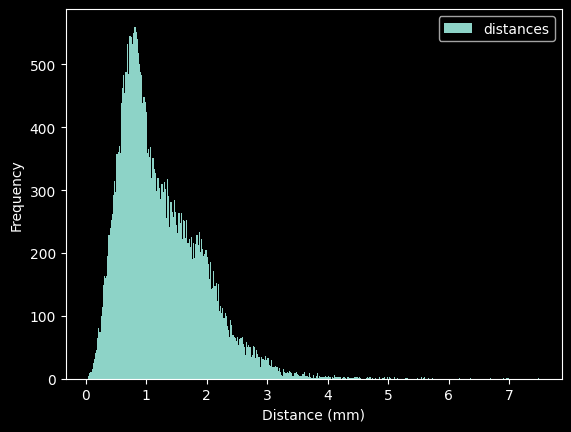

In [21]:
import pandas as pd
pc_1 = o3d.io.read_point_cloud("C:/Users/jacop/Desktop/confronto_mesh/NUOVALORO.xyz")
pc_2 = o3d.io.read_point_cloud("C:/Users/jacop/Desktop/confronto_mesh/NUOVANOSTRA.xyz")
pc_2.paint_uniform_color((0,1,0))
o3d.visualization.draw_geometries([pc_1, pc_2])

#plt.style.use('dark_background')
dist_pc1_pc2 = np.asarray(pc_1.compute_point_cloud_distance(pc_2))
dist_medici = pd.DataFrame({"distances": dist_pc1_pc2}) # transform to a dataframe
ax3 = dist_medici.plot(kind="hist", alpha=1, bins = 400) # HISTOGRAM
plt.xlabel("Distance (mm)")
plt.show()

In [5]:
import pandas as pd
import point_cloud_utils as pcu

pc_1 = o3d.io.read_point_cloud("C:/Users/jacop/Desktop/confronto_mesh/NUOVALORO.xyz")
pc_2 = o3d.io.read_point_cloud("C:/Users/jacop/Desktop/confronto_mesh/NUOVANOSTRA.xyz")
pc_2.paint_uniform_color((0,1,0))
#o3d.visualization.draw_geometries([pc_1, pc_2])



#plt.style.use('dark_background')
#dist_pc1_pc2 = np.asarray(pc_1.compute_point_cloud_distance(pc_2))
pc_1 = np.asarray(pc_1.points)
pc_2 = np.asarray(pc_2.points)

hausdorff_a_to_b = pcu.one_sided_hausdorff_distance(pc_1, pc_2)
hausdorff_b_to_a = pcu.one_sided_hausdorff_distance(pc_2, pc_1)

hausdorff_dist = pcu.hausdorff_distance(pc_1, pc_2)


dist_pc1_pc2 = np.asarray(hausdorff_dist)
print(dist_pc1_pc2)
#dist_medici = pd.DataFrame({"distances": dist_pc1_pc2}) # transform to a dataframe
#ax3 = dist_medici.plot(kind="hist", alpha=1, bins = 400) # HISTOGRAM
#plt.xlabel("Distance (mm)")
#plt.show()

7.498569322002498


In [22]:
dist_medici.std()

distances    0.684016
dtype: float64

In [6]:
rmse_cal = np.sqrt(np.sum(np.power(df_calibrated.get('distances'), 2))/len(df_calibrated.get('distances')))

rmse_notcal = np.sqrt(np.sum(np.power(df_notcalibrated.get('distances'), 2))/len(df_notcalibrated.get('distances')))

In [7]:
print(rmse_cal)
print(rmse_notcal)

0.0037294415571308913
0.058272879774004915


In [8]:
rmse_notcal/rmse_cal

15.625095307522399

In [36]:
print(df_calibrated.mean())
print(df_notcalibrated.mean())

distances    0.000569
dtype: float64
distances    0.056128
dtype: float64


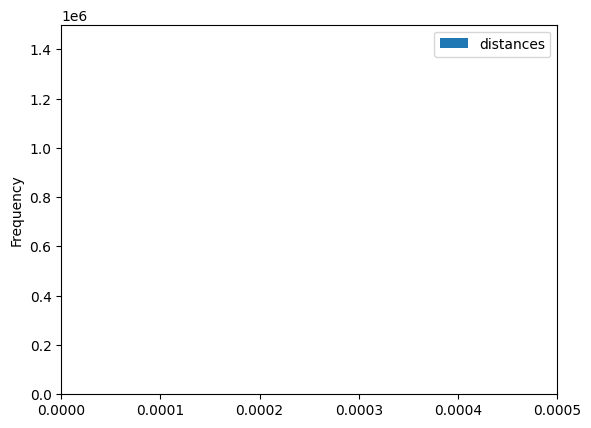

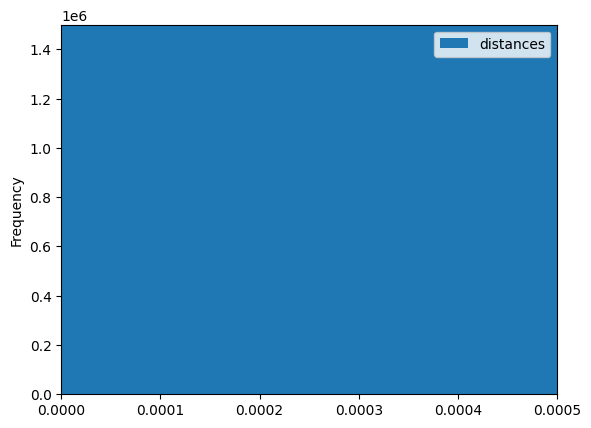

In [38]:
# Some graphs
ax3 = df_notcalibrated.plot(kind="hist", alpha=1, bins = 300, xlim=(0, 0.0005), ylim=(0, 1.5*1e6)) # HISTOGRAM
ax4 = df_calibrated.plot(kind="hist", alpha=1, bins = 300, xlim=(0, 0.0005), ylim=(0, 1.5*1e6)) # HISTOGRAM
plt.show()

In [84]:
pcd_l = o3d.io.read_point_cloud('acquisizioni/calibrato/1_l.pcd')
pcd_r = o3d.io.read_point_cloud('acquisizioni/calibrato/1_r.pcd')
pcd = o3d.io.read_point_cloud('acquisizioni/calibrato/1.pcd')
pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.01, max_nn=200))
pcd_l.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.01, max_nn=200))
pcd_r.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.01, max_nn=200))
#pcd.estimate_normals()
pcd_l.orient_normals_consistent_tangent_plane(50)
pcd_r.orient_normals_consistent_tangent_plane(50)
pcd.orient_normals_consistent_tangent_plane(50)
#o3d.visualization.draw_geometries([pcd])
#pcd

In [85]:
o3d.visualization.draw_geometries([pcd_l])

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: Handle non valido. 


In [90]:
downpcd = pcd.voxel_down_sample(voxel_size=0.001)
downpcd.orient_normals_consistent_tangent_plane(100)
o3d.visualization.draw_geometries([downpcd])
print(downpcd.points)

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: Handle non valido. 
std::vector<Eigen::Vector3d> with 79823 elements.
Use numpy.asarray() to access data.


In [94]:
radii = [0.001]
rec_mesh_l = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
    pcd_l, o3d.utility.DoubleVector(radii))
rec_mesh_r = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
    pcd_r, o3d.utility.DoubleVector(radii))
rec_mesh_l = rec_mesh_l.filter_smooth_simple(number_of_iterations=5)
rec_mesh_r = rec_mesh_r.filter_smooth_simple(number_of_iterations=5)
rec_mesh_r.compute_vertex_normals()
rec_mesh_l.compute_vertex_normals()
rec_mesh_r.paint_uniform_color(np.array([[0.1],[0.6],[0.9]]))
rec_mesh_l.paint_uniform_color(np.array([[0.9],[0.6],[0.1]]))
o3d.visualization.draw_geometries([rec_mesh_l, rec_mesh_r], mesh_show_back_face=True)

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: Handle non valido. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: L'operazione di trasformazione richiesta non è supportata. 


In [76]:
radii = [0.001]
rec_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
    pcd, o3d.utility.DoubleVector(radii))
o3d.visualization.draw_geometries([rec_mesh], mesh_show_back_face=True)

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: Handle non valido. 


In [81]:
print('run Poisson surface reconstruction')
with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
        pcd, depth=9)
    mesh.compute_vertex_normals()
    mesh.paint_uniform_color(np.array([[0.5],[0.5],[0.5]]))
print(mesh)
o3d.visualization.draw_geometries([mesh])

run Poisson surface reconstruction
[Open3D DEBUG] Input Points / Samples: 218622 / 115754
[Open3D DEBUG] #   Got kernel density: 0.0339999 (s), 1230.45 (MB) / 1492.86 (MB) / 1625 (MB)
[Open3D DEBUG] #     Got normal field: 0.186 (s), 1229.36 (MB) / 1492.86 (MB) / 1625 (MB)
[Open3D DEBUG] Point weight / Estimated Area: 3.149017e-06 / 6.884444e-01
[Open3D DEBUG] #       Finalized tree: 0.164 (s), 1262.84 (MB) / 1492.86 (MB) / 1625 (MB)
[Open3D DEBUG] #  Set FEM constraints: 0.225 (s), 1245.38 (MB) / 1492.86 (MB) / 1625 (MB)
[Open3D DEBUG] #Set point constraints: 0.0640001 (s), 1243.61 (MB) / 1492.86 (MB) / 1625 (MB)
[Open3D DEBUG] Leaf Nodes / Active Nodes / Ghost Nodes: 1039291 / 1184424 / 3337
[Open3D DEBUG] Memory Usage: 1243.613 MB
[Open3D DEBUG] # Linear system solved: 0.536 (s), 1268.35 (MB) / 1492.86 (MB) / 1625 (MB)
[Open3D DEBUG] Got average: 0.00999999 (s), 1246.8 (MB) / 1492.86 (MB) / 1625 (MB)
[Open3D DEBUG] Iso-Value: 5.015619e-01 = 1.096525e+05 / 2.186220e+05
[Open3D DEBUG]

In [121]:
print('visualize densities')
densities = np.asarray(densities)
density_colors = plt.get_cmap('plasma')(
    (densities - densities.min()) / (densities.max() - densities.min()))
density_colors = density_colors[:, :3]
density_mesh = o3d.geometry.TriangleMesh()
density_mesh.vertices = mesh.vertices
density_mesh.triangles = mesh.triangles
density_mesh.triangle_normals = mesh.triangle_normals
density_mesh.vertex_colors = o3d.utility.Vector3dVector(density_colors)
o3d.visualization.draw_geometries([density_mesh])

visualize densities
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: Handle non valido. 


In [122]:
print('remove low density vertices')
vertices_to_remove = densities < np.quantile(densities, 0.1)
mesh.remove_vertices_by_mask(vertices_to_remove)
print(mesh)
o3d.visualization.draw_geometries([mesh])

remove low density vertices
TriangleMesh with 25049 points and 49622 triangles.
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: L'operazione di trasformazione richiesta non è supportata. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: L'operazione di trasformazione richiesta non è supportata. 


# TEST

In [42]:
d_l, v_l, m_l, in_l, col_l, d_r, v_r, m_r, in_r, col_r, intr_left, intr_right = acquire(90)

Acquisizione iniziata
Acquisizione finita


In [44]:
variance_image_l, zero_variance_image_l, threshold_l, filtered_means_l = get_maps(v_l, m_l, 2)
variance_image_r, zero_variance_image_r, threshold_r, filtered_means_r = get_maps(v_r, m_r, 2)

Threshold: 0.35111111111111115
Threshold: 0.3388888888888888


In [45]:
indexes = np.argwhere(variance_image_l == 255)
selected_m_l = np.copy(m_l)
selected_m_l[indexes[:,0], indexes[:,1]] = 0
cv2.imwrite("./acquisizioni/tre/leftDepth.png", np.uint16(selected_m_l))
cv2.imwrite("./acquisizioni/tre/leftColor.jpg", col_l)

indexes = np.argwhere(variance_image_r == 255)
selected_m_r = np.copy(m_r)
selected_m_r[indexes[:,0], indexes[:,1]] = 0
cv2.imwrite("./acquisizioni/tre/rightDepth.png", np.uint16(selected_m_r))
cv2.imwrite("./acquisizioni/tre/rightColor.jpg", col_r)


depth_raw_left = o3d.io.read_image("./acquisizioni/tre/leftDepth.png")
color_raw_left = o3d.io.read_image("./acquisizioni/tre/leftColor.jpg")
depth_raw_right = o3d.io.read_image("./acquisizioni/tre/rightDepth.png")
color_raw_right = o3d.io.read_image("./acquisizioni/tre/rightColor.jpg")
rgbd_image_left = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw_left, depth_raw_left)
rgbd_image_right = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw_right, depth_raw_right)

In [46]:
camera_intrinsic_left = o3d.camera.PinholeCameraIntrinsic(o3d.camera.PinholeCameraIntrinsic(
        intr_left.width, intr_left.height, intr_left.fx, intr_left.fy, intr_left.ppx, intr_left.ppy
    ))
camera_intrinsic_right = o3d.camera.PinholeCameraIntrinsic(o3d.camera.PinholeCameraIntrinsic(
    intr_right.width, intr_right.height, intr_right.fx, intr_right.fy, intr_right.ppx, intr_right.ppy
))

pcd_left = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image_left, camera_intrinsic_left)
pcd_right = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image_right, camera_intrinsic_right)

bounds = [[-math.inf, math.inf], [-math.inf, math.inf], [0.1, 0.7]]  # set the bounds
bounding_box_points = list(itertools.product(*bounds))  # create limit points
bounding_box = o3d.geometry.AxisAlignedBoundingBox.create_from_points(o3d.utility.Vector3dVector(bounding_box_points))  # create bounding box object

# Crop the point cloud using the bounding box:
pcd_left = pcd_left.crop(bounding_box)
pcd_right = pcd_right.crop(bounding_box)

# Rotazione di 180° intorno all'asse X (ribaltare la point cloud poiché la pinhole camera ribalta la visuale)
angolo = np.pi
trans_x = np.asarray([   [1.0, 0.0, 0.0, 0.0],
                        [0.0, np.cos(angolo), -np.sin(angolo), 0.0],
                        [0.0, np.sin(angolo), np.cos(angolo), 0.0],
                        [0.0, 0.0, 0.0, 1.0]])

pcd_left.transform(trans_x)
pcd_right.transform(trans_x)
matrice_calibrazione = np.asarray([[ 0.84331559, -0.03637172, -0.53618646, -0.31376034],
       [ 0.05632811,  0.99819392,  0.02088142, -0.01124673],
       [ 0.53445857, -0.047812  ,  0.84384124, -0.10226705],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

pcd_left.transform(matrice_calibrazione)

#pcd_left.paint_uniform_color((1,0,0))  # LEFT BLU

#pcd_right.paint_uniform_color((0,0,1)) # RIGHT ROSSO

#o3d.visualization.draw_geometries([pcd_left, pcd_right])
print("pointcloud ",100)
save_pcl(100, pcd_left, pcd_right, 'tre')

pointcloud  100


True

In [48]:
def display_inlier_outlier(cloud, ind):
    inlier_cloud = cloud.select_by_index(ind)
    outlier_cloud = cloud.select_by_index(ind, invert=True)

    print("Showing outliers (red) and inliers (gray): ")
    outlier_cloud.paint_uniform_color([1, 0, 0])
    inlier_cloud.paint_uniform_color([0.8, 0.8, 0.8])
    o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud])
    return inlier_cloud

In [58]:
pcd = o3d.io.read_point_cloud('acquisizioni/calibrato02-05/1_l.pcd')

cl, ind = pcd.remove_statistical_outlier(nb_neighbors=300, std_ratio=1.0)
pulita = display_inlier_outlier(pcd, ind)
pulita.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.003, max_nn=500))
pulita.orient_normals_consistent_tangent_plane(30)

downpcd = pulita.voxel_down_sample(voxel_size=0.0008)


Showing outliers (red) and inliers (gray): 


In [59]:
print(pcd)
print(downpcd)

PointCloud with 91178 points.
PointCloud with 55607 points.


In [101]:
pcd_l = o3d.io.read_point_cloud('acquisizioni/noncalibrato10-05/1_l.pcd')
pcd_r = o3d.io.read_point_cloud('acquisizioni/noncalibrato10-05/1_r.pcd')
#downpcd = pcd.voxel_down_sample(voxel_size=0.001)
print(pcd)
#print(downpcd)
pcd_l.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.008, max_nn=500))
pcd_r.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.008, max_nn=500))
pcd_r.orient_normals_consistent_tangent_plane(50)
pcd_l.orient_normals_consistent_tangent_plane(50)
pcd_l.paint_uniform_color((1,0,0))
pcd_r.paint_uniform_color((0,0,1))
o3d.visualization.draw_geometries([pcd_l, pcd_r])

PointCloud with 108460 points.


In [107]:
pcd_l = o3d.io.read_point_cloud('acquisizioni/test005/4_l.pcd')
pcd_r = o3d.io.read_point_cloud('acquisizioni/test005/4_r.pcd')
#downpcd = pcd.voxel_down_sample(voxel_size=0.001)
print(pcd)
#print(downpcd)
pcd_l.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.008, max_nn=500))
pcd_r.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.008, max_nn=500))
pcd_r.orient_normals_consistent_tangent_plane(50)
pcd_l.orient_normals_consistent_tangent_plane(50)
pcd_l.paint_uniform_color((1,0,0))
pcd_r.paint_uniform_color((0,0,1))
o3d.visualization.draw_geometries([pcd_l, pcd_r])

PointCloud with 108460 points.


In [60]:
radii = [0.001]
rec_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
    pulita, o3d.utility.DoubleVector(radii))
rec_mesh.compute_vertex_normals()
#rec_mesh.filter_smooth_laplacian(lambda_filter=0.9)
o3d.visualization.draw_geometries([rec_mesh], mesh_show_back_face=False)

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: Handle non valido. 


In [61]:
print('run Poisson surface reconstruction')
with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
        downpcd, depth=9)
    
    mesh.paint_uniform_color(np.array([[0.5],[0.5],[0.5]]))
mesh = mesh.filter_smooth_laplacian()
mesh.compute_triangle_normals()
mesh.compute_vertex_normals()
print(mesh)
o3d.visualization.draw_geometries([mesh])


run Poisson surface reconstruction
[Open3D DEBUG] Input Points / Samples: 55607 / 48625
[Open3D DEBUG] #   Got kernel density: 0.0190001 (s), 1038.84 (MB) / 1539.54 (MB) / 1852 (MB)
[Open3D DEBUG] #     Got normal field: 0.118 (s), 1039.0 (MB) / 1539.54 (MB) / 1852 (MB)
[Open3D DEBUG] Point weight / Estimated Area: 8.071805e-06 / 4.488488e-01
[Open3D DEBUG] #       Finalized tree: 0.101000 (s), 1060.46 (MB) / 1539.54 (MB) / 1852 (MB)
[Open3D DEBUG] #  Set FEM constraints: 0.125 (s), 1049.35 (MB) / 1539.54 (MB) / 1852 (MB)
[Open3D DEBUG] #Set point constraints: 0.0319998 (s), 1048.21 (MB) / 1539.54 (MB) / 1852 (MB)
[Open3D DEBUG] Leaf Nodes / Active Nodes / Ghost Nodes: 661802 / 752824 / 3521
[Open3D DEBUG] Memory Usage: 1048.207 MB
[Open3D DEBUG] # Linear system solved: 0.342 (s), 1062.61 (MB) / 1539.54 (MB) / 1852 (MB)
[Open3D DEBUG] Got average: 0.00700021 (s), 1052.01 (MB) / 1539.54 (MB) / 1852 (MB)
[Open3D DEBUG] Iso-Value: 5.002653e-01 = 2.781825e+04 / 5.560700e+04
[Open3D DEBUG] 

In [16]:
o3d.io.write_triangle_mesh('./acquisizioni/tre/test.obj', mesh)

[Open3D WARNING] Write OBJ can not include triangle normals.


True

In [5]:
pcd = o3d.io.read_point_cloud('acquisizioni/tre/1_l.pcd')
#downpcd = pcd.voxel_down_sample(voxel_size=0.001)
print(pcd)
#print(downpcd)
pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.008, max_nn=500))
pcd.orient_normals_consistent_tangent_plane(50)
o3d.visualization.draw_geometries([pcd])
print('run Poisson surface reconstruction')
with o3d.utility.VerbosityContextManager(o3d.utility.VerbosityLevel.Debug) as cm:
    mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=9)
    mesh.paint_uniform_color(np.array([[0.5],[0.5],[0.5]]))
mesh = mesh.filter_smooth_laplacian()
mesh.compute_triangle_normals()
mesh.compute_vertex_normals()

print('visualize densities')
densities = np.asarray(densities)
density_colors = plt.get_cmap('plasma')(
    (densities - densities.min()) / (densities.max() - densities.min()))
density_colors = density_colors[:, :3]
density_mesh = o3d.geometry.TriangleMesh()
density_mesh.vertices = mesh.vertices
density_mesh.triangles = mesh.triangles
density_mesh.triangle_normals = mesh.triangle_normals
density_mesh.vertex_colors = o3d.utility.Vector3dVector(density_colors)
o3d.visualization.draw_geometries([density_mesh])

print('remove low density vertices')
vertices_to_remove = densities < np.quantile(densities, 0.1)
mesh.remove_vertices_by_mask(vertices_to_remove)
print(mesh)
o3d.visualization.draw_geometries([mesh])
o3d.io.write_triangle_mesh('./acquisizioni/tre/left.obj', mesh)

pcd = o3d.io.read_point_cloud('acquisizioni/tre/1_r.pcd')
#downpcd = pcd.voxel_down_sample(voxel_size=0.001)
print(pcd)
#print(downpcd)
pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.008, max_nn=500))
pcd.orient_normals_consistent_tangent_plane(50)
o3d.visualization.draw_geometries([pcd])
print('run Poisson surface reconstruction')
with o3d.utility.VerbosityContextManager(o3d.utility.VerbosityLevel.Debug) as cm:
    mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=9)
    mesh.paint_uniform_color(np.array([[0.5],[0.5],[0.5]]))
mesh = mesh.filter_smooth_laplacian()
mesh.compute_triangle_normals()
mesh.compute_vertex_normals()

print('visualize densities')
densities = np.asarray(densities)
density_colors = plt.get_cmap('plasma')(
    (densities - densities.min()) / (densities.max() - densities.min()))
density_colors = density_colors[:, :3]
density_mesh = o3d.geometry.TriangleMesh()
density_mesh.vertices = mesh.vertices
density_mesh.triangles = mesh.triangles
density_mesh.triangle_normals = mesh.triangle_normals
density_mesh.vertex_colors = o3d.utility.Vector3dVector(density_colors)
o3d.visualization.draw_geometries([density_mesh])

print('remove low density vertices')
vertices_to_remove = densities < np.quantile(densities, 0.1)
mesh.remove_vertices_by_mask(vertices_to_remove)
print(mesh)
o3d.visualization.draw_geometries([mesh])

o3d.io.write_triangle_mesh('./acquisizioni/tre/right.obj', mesh)

PointCloud with 105822 points.
run Poisson surface reconstruction
[Open3D DEBUG] Input Points / Samples: 105822 / 29394
[Open3D DEBUG] #   Got kernel density: 0.00900006 (s), 391.219 (MB) / 391.219 (MB) / 738 (MB)
[Open3D DEBUG] #     Got normal field: 0.0409999 (s), 391.609 (MB) / 391.609 (MB) / 738 (MB)
[Open3D DEBUG] Point weight / Estimated Area: 1.611464e-06 / 1.705283e-01
[Open3D DEBUG] #       Finalized tree: 0.0489998 (s), 402.57 (MB) / 402.57 (MB) / 738 (MB)
[Open3D DEBUG] #  Set FEM constraints: 0.086 (s), 396.629 (MB) / 402.57 (MB) / 738 (MB)
[Open3D DEBUG] #Set point constraints: 0.0149999 (s), 396.773 (MB) / 402.57 (MB) / 738 (MB)
[Open3D DEBUG] Leaf Nodes / Active Nodes / Ghost Nodes: 327335 / 372728 / 1369
[Open3D DEBUG] Memory Usage: 396.773 MB
[Open3D DEBUG] # Linear system solved: 0.246 (s), 400.035 (MB) / 402.57 (MB) / 738 (MB)
[Open3D DEBUG] Got average: 0.00499988 (s), 398.609 (MB) / 402.57 (MB) / 738 (MB)
[Open3D DEBUG] Iso-Value: 5.050603e-01 = 5.344649e+04 / 1.0

True